# Modeling Heisman Candidates
***Sean Steinle***


In this notebook we'll synthesize our data into one file and model our candidates.

## Table of Contents

1. [Remaining Data Cleaning](#1)
2. [Modeling and Machine Learning](#2)
    1. [Unsupervised Learning](#2a)
    2. [Linear Regression](#2b)
    3. [Neural Network](#2c)

<a id='1'></a>

## Remaining Data Cleaning

In this section, we'll be reorganizing our data one more time before we finally perform inferential statistics.

In [26]:
#import libraries
import cfbd
import pandas as pd
import time
import sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
df_qb = pd.read_csv("../data/heisman_QBs.csv")
df_rb = pd.read_csv("../data/heisman_RBs.csv")
df_wr = pd.read_csv("../data/heisman_WRs.csv")
df_rb["POS"] = "RB"
df_wr["POS"] = "WR"

In [3]:
#Only run one time: will paste over manual edits!
#This code creates numeric variables for class, school, and position (position for RB and WR)
df_rbwr = pd.concat([df_rb,df_wr],axis=0)
df_rbwr["ClassNum"] = pd.factorize(df_rbwr["Class"])[0]
df_rbwr["SchoolNum"] = pd.factorize(df_rbwr["School"])[0]
df_rbwr["POSNum"] = pd.factorize(df_rbwr["POS"])[0]

df_qb["ClassNum"] = pd.factorize(df_qb["Class"])[0]
df_qb["SchoolNum"] = pd.factorize(df_qb["School"])[0]
#df_rbwr.to_csv("../data/Heisman_RBWRs_.csv")
#df_qb.to_csv("../data/Heisman_QBs_.csv")

At this point, I'll do a few edits to remove superfluous columns and to format the .csv better.

In [80]:
df_rbwr = pd.read_csv("../data/Heisman_RBWRs.csv")
df_qb = pd.read_csv("../data/Heisman_QBs.csv")

In [81]:
#create a DF with all numeric attributes for modeling. found non-numerics to drop with df_qb.dtypes
#drop School, Class, POS (for rbwr)
df_qb_num = df_qb.drop(columns=['School','Class'])
df_rbwr_num = df_rbwr.drop(columns=['School','Class','POS'])

<a id='2a'></a>

## Unsupervised Learning

In this section we will conduct k-means clustering on our dataframes to see if we can predict Heisman winners from their dimensions alone, without using the vote share labels we will use in supervised learning. After clustering, we will reduce our data two two dimensions using PCA, a dimensionality reduction technique.

In [187]:
#here we create an instance of our clustering algorithm to create 3 clusters in each of our datasets
kmeans = KMeans(n_clusters=3, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
df_qb_num['Cluster'] = kmeans.fit_predict(df_qb_num.drop(columns=['NAME','1stVotes','2ndVotes','3rdVotes','TotalVotes','1stVoteShare','TotalPointShare']))
df_rbwr_num['Cluster'] = kmeans.fit_predict(df_rbwr_num.drop(columns=['NAME','1stVotes','2ndVotes','3rdVotes','TotalVotes','1stVoteShare','TotalPointShare']))

#here, we're using PCA (principal component analysis) to reduce the values of our data attributes down to only two dimensions for
#the purpose of visualizing all of the different attributes together
pca = sklearn.decomposition.PCA(n_components=2)
trans_df = pd.DataFrame(pca.fit_transform(df_qb_num.drop(columns=['NAME','1stVotes','2ndVotes','3rdVotes','TotalVotes','1stVoteShare','TotalPointShare'])), columns=['X','Y'])
df_qb_num["X"] = trans_df["X"]
df_qb_num["Y"] = trans_df["Y"]

trans_df = pd.DataFrame(pca.fit_transform(df_rbwr_num.drop(columns=['NAME','1stVotes','2ndVotes','3rdVotes','TotalVotes','1stVoteShare','TotalPointShare'])), columns=['X','Y'])
df_rbwr_num["X"] = trans_df["X"]
df_rbwr_num["Y"] = trans_df["Y"]

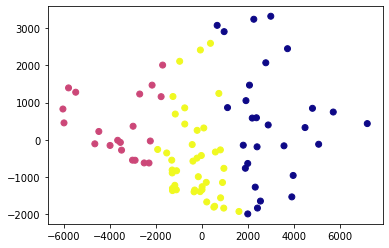

In [188]:
plt.scatter(df_qb_num["X"],df_qb_num["Y"],c=df_qb_num["Cluster"],cmap='plasma')

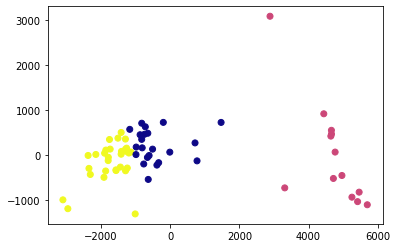

In [189]:
plt.scatter(df_rbwr_num["X"],df_rbwr_num["Y"],c=df_rbwr_num["Cluster"],cmap='plasma')

In [185]:
qb_clusters = df_qb_num.groupby(['Cluster'])
print(qb_clusters['1stVoteShare'].mean())
print(qb_clusters['X'].mean())
print(qb_clusters['Y'].mean())
#for name,group in qb_clusters:
#    print(name,group)

Cluster
0    0.103587
1    0.123183
2    0.227042
Name: 1stVoteShare, dtype: float64
Cluster
0    -129.176924
1    2849.094086
2   -3269.095971
Name: X, dtype: float64
Cluster
0   -476.748483
1    512.965696
2    318.396581
Name: Y, dtype: float64


In [186]:
rbwr_clusters = df_rbwr_num.groupby(['Cluster'])
print(rbwr_clusters['1stVoteShare'].mean())
print(qb_clusters['X'].mean())
print(qb_clusters['Y'].mean())
#for name,group in rbwr_clusters:
#    print(name,group)

Cluster
0    0.073171
1    0.060535
2    0.046469
Name: 1stVoteShare, dtype: float64
Cluster
0    -129.176924
1    2849.094086
2   -3269.095971
Name: X, dtype: float64
Cluster
0   -476.748483
1    512.965696
2    318.396581
Name: Y, dtype: float64


**Conclusion**

hm this went okay!

<a id='2b'></a>

## Linear Regression

in this section...

In [151]:
Xqb = df_qb_num.drop(columns=['NAME','1stVotes','2ndVotes','3rdVotes','TotalVotes','TotalPointShare','1stVoteShare','X','Y'])
Yqb = df_qb_num['1stVoteShare']
Xrbwr = df_rbwr_num.drop(columns=['NAME','1stVotes','2ndVotes','3rdVotes','TotalVotes','TotalPointShare','1stVoteShare','X','Y'])
Yrbwr = df_rbwr_num['1stVoteShare']

In [152]:
Xqb_train, Xqb_test, Yqb_train, Yqb_test = train_test_split(Xqb, Yqb, test_size=0.2)
Xrbwr_train, Xrbwr_test, Yrbwr_train, Yrbwr_test = train_test_split(Xrbwr, Yrbwr, test_size=0.2)

In [160]:
lr_qb = LinearRegression()
lr_qb.fit(Xqb_train,Yqb_train)
print(lr_qb.score(Xqb_test,Yqb_test))

lr_rbwr = LinearRegression()
lr_rbwr.fit(Xrbwr_train,Yrbwr_train)
print(lr_rbwr.score(Xrbwr_test,Yrbwr_test))

0.23596809092731574
-2.167459597293352


Text(0.5, 1.0, 'Actual vs. Projected Shared of 1st Place Votes')

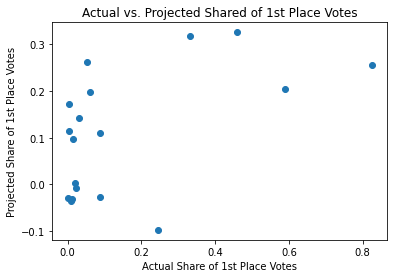

In [161]:
preds = lr_qb.predict(Xqb_test)
plt.scatter(Yqb_test,preds)
plt.xlabel("Actual Share of 1st Place Votes")
plt.ylabel("Projected Share of 1st Place Votes")
plt.title("Actual vs. Projected Shared of 1st Place Votes")

Text(0.5, 1.0, 'Actual vs. Projected Shared of 1st Place Votes')

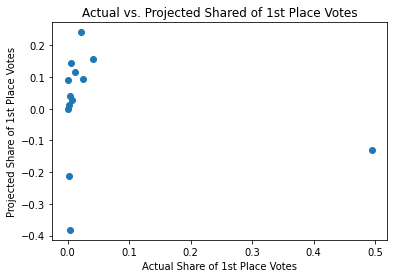

In [162]:
preds = lr_rbwr.predict(Xrbwr_test)
plt.scatter(Yrbwr_test,preds)
plt.xlabel("Actual Share of 1st Place Votes")
plt.ylabel("Projected Share of 1st Place Votes")
plt.title("Actual vs. Projected Shared of 1st Place Votes")

**Conclusion**

linear regression doesn't describe this very well because it is an unbalanced dataset!

<a id='2c'></a>
## Neural Networks



In [172]:
Xqb = df_qb_num.drop(columns=['NAME','1stVotes','2ndVotes','3rdVotes','TotalVotes','TotalPointShare','1stVoteShare','X','Y'])
Yqb = df_qb_num['1stVoteShare']
Xrbwr = df_rbwr_num.drop(columns=['NAME','1stVotes','2ndVotes','3rdVotes','TotalVotes','TotalPointShare','1stVoteShare','X','Y'])
Yrbwr = df_rbwr_num['1stVoteShare']

In [173]:
Xqb_train, Xqb_test, Yqb_train, Yqb_test = train_test_split(Xqb, Yqb, test_size=0.2)
Xrbwr_train, Xrbwr_test, Yrbwr_train, Yrbwr_test = train_test_split(Xrbwr, Yrbwr, test_size=0.2)

In [174]:
mlp_qb = MLPRegressor(activation='logistic',random_state=0)
mlp_qb.fit(Xqb_train,Yqb_train)
print(mlp_qb.score(Xqb_test,Yqb_test))

mlp_rbwr = MLPRegressor(activation='logistic',random_state=0)
mlp_rbwr.fit(Xrbwr_train,Yrbwr_train)
print(mlp_rbwr.score(Xrbwr_test,Yrbwr_test))

-0.17282572879604463
-2.7706583495931634


Text(0.5, 1.0, 'Actual vs. Projected Shared of 1st Place Votes')

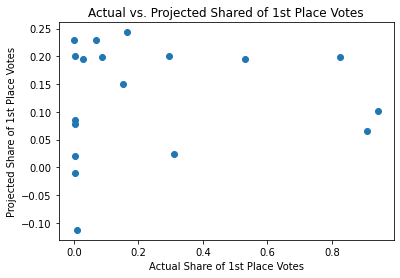

In [175]:
preds = mlp_qb.predict(Xqb_test)
plt.scatter(Yqb_test,preds)
plt.xlabel("Actual Share of 1st Place Votes")
plt.ylabel("Projected Share of 1st Place Votes")
plt.title("Actual vs. Projected Shared of 1st Place Votes")

Text(0.5, 1.0, 'Actual vs. Projected Shared of 1st Place Votes')

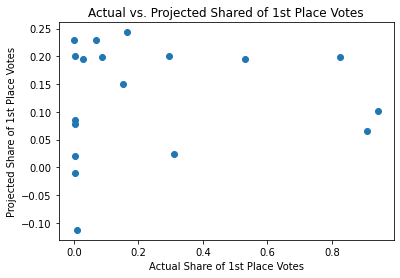

In [176]:
preds = mlp_qb.predict(Xqb_test)
plt.scatter(Yqb_test,preds)
plt.xlabel("Actual Share of 1st Place Votes")
plt.ylabel("Projected Share of 1st Place Votes")
plt.title("Actual vs. Projected Shared of 1st Place Votes")

**Conclusion**

This is also not good